#SetUp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 20.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from underthesea import text_normalize, word_tokenize
import unicodedata


#Data Set


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/scraped.csv')
df.head()

,title,link,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,https://vietnamnet.vn/khong-chinh-tri-hoa-cac-...,Politics
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,https://vietnamnet.vn/thu-tuong-trung-quoc-va-...,Politics
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,https://vietnamnet.vn/thu-tuong-khai-truong-kh...,Politics
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,https://vietnamnet.vn/thu-tuong-de-nghi-indone...,Politics
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",https://vietnamnet.vn/thu-tuong-mong-doanh-ngh...,Politics


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59958 entries, 0 to 59957
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     59958 non-null  object
 1   link      59958 non-null  object
 2   category  59958 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


#Pre-processing


In [ ]:
category_mapping = {
    'Politics': 0,
    'Business': 1,
    'Sports': 2,
    'Education': 3,
    'Wellness': 4,
    'Entertainment': 5
}

df.drop(columns=['link'], inplace=True)

df['category'] = df['category'].map(category_mapping)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",0


In [ ]:
import unicodedata


def unicode_normalize(text):
    return unicodedata.normalize('NFC', text)

df['title'] = df['title'].apply(unicode_normalize)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",0


## Remove special characters and numbers

In [ ]:
def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['title'] = df['title'].apply(clean_text)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng Trung Quốc và ASEAN cần mở cửa thị t...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,Thủ tướng mong doanh nghiệp ASEAN đoàn kết tro...,0


## Spelling normalization

In [ ]:
def spelling_normalize(text):
    text = text.replace('kĩ','kỹ').replace('mỳ', 'mì').replace('sỹ', 'sĩ').replace('lí ',' lý ')

    return text

df['title'] = df['title'].apply(spelling_normalize).apply(text_normalize)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng Trung Quốc và ASEAN cần mở cửa thị t...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,Thủ tướng mong doanh nghiệp ASEAN đoàn kết tro...,0


##Tokenization


In [ ]:

tkn_df = df.copy()

tkn_df['title'] = tkn_df['title'].apply(lambda sentence: word_tokenize(sentence, format='text'))

tkn_df.head()

,title,category
0,Việt_Nam sẵn_sàng cùng IMF triển_khai các biện...,0
1,Thủ_tướng Trung_Quốc và ASEAN cần mở_cửa thị_t...,0
2,Thủ_tướng khai_trương khu gian_hàng Việt_Nam t...,0
3,Thủ_tướng đề_nghị Indonesia công_nhận nỗ_lực c...,0
4,Thủ_tướng mong doanh_nghiệp ASEAN đoàn_kết tro...,0


## Capitalization (lower case)

In [ ]:
tkn_df['title'] = tkn_df['title'].str.lower()

tkn_df.head()

,title,category
0,việt_nam sẵn_sàng cùng imf triển_khai các biện...,0
1,thủ_tướng trung_quốc và asean cần mở_cửa thị_t...,0
2,thủ_tướng khai_trương khu gian_hàng việt_nam t...,0
3,thủ_tướng đề_nghị indonesia công_nhận nỗ_lực c...,0
4,thủ_tướng mong doanh_nghiệp asean đoàn_kết tro...,0


## Stopwords

In [ ]:
with open('/content/drive/MyDrive/ML/stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords]
print(stopwords)

['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc', 'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của', 'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều', 'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'hơn', 'ít', 'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một', 'một_cách', 'này', 'nên', 'nếu', 'ngay', 'nhất', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'ở', 'phải', 'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ', 'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trong', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'về', 'vì', 'việc', 'với', 'vừa']


## Remove stopwords

In [ ]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

tkn_df['title'] = tkn_df['title'].apply(remove_stopwords)
tkn_df.head()

,title,category
0,việt_nam sẵn_sàng imf triển_khai biện_pháp thú...,0
1,thủ_tướng trung_quốc asean mở_cửa thị_trường c...,0
2,thủ_tướng khai_trương khu gian_hàng việt_nam h...,0
3,thủ_tướng đề_nghị indonesia công_nhận nỗ_lực v...,0
4,thủ_tướng mong doanh_nghiệp asean đoàn_kết tôi...,0


# Feature extraction (TF-IDF)

In [ ]:
corpus = tkn_df.copy()
corpus['title'] = corpus['title'].astype(str)

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
features = vectorizer.fit_transform(corpus['title'])
tfidf_df = pd.DataFrame(data=features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df['category'] = corpus['category']
tfidf_df.head()

,a_bank,a_vòng,ac,adeno,afc,aff,aff_cup,agribank,ai,ai_cập,...,ủy,ủy_ban,ủy_viên,ức_chế,ứng_cử,ứng_dụng,ứng_phó,ứng_viên,ứng_xử,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Data splitting

In [ ]:
train_df, temp_df = train_test_split(tfidf_df, test_size=0.2, stratify=tfidf_df['category'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)

# Hyperparameter tuning

In [ ]:
X_train = train_df.drop(columns=['category'])
y_train = train_df['category']

X_val = val_df.drop(columns=['category'])
y_val = val_df['category']

X_test = test_df.drop(columns=['category'])
y_test = test_df['category']

#Models training



## Naive Bayes

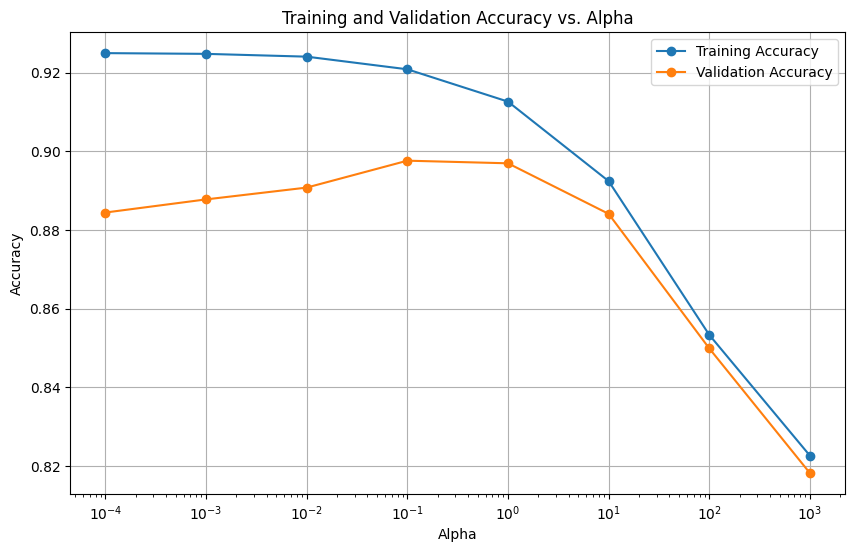

['clf3.joblib']

In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.grid(True)
plt.legend()
plt.show()
clf0 = 'clf0.joblib'
joblib.dump(clf, clf0)

##K-Nearest Neighbors


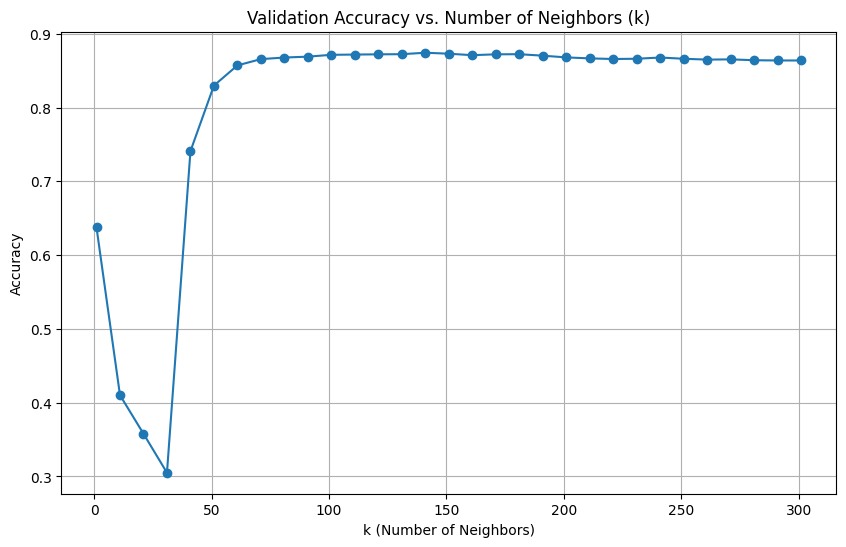

In [ ]:
k_values = range(1, 302, 10)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()

## Support Vector Machine

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


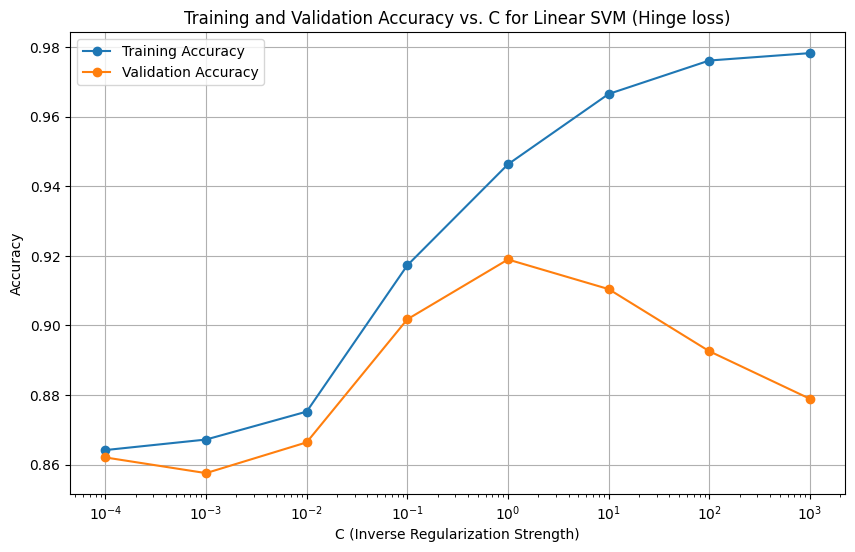

In [ ]:

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    clf = LinearSVC(C=C, loss='hinge', max_iter=10000)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Linear SVM (Hinge loss)')
plt.grid(True)
plt.legend()
plt.show()

## Random Forest

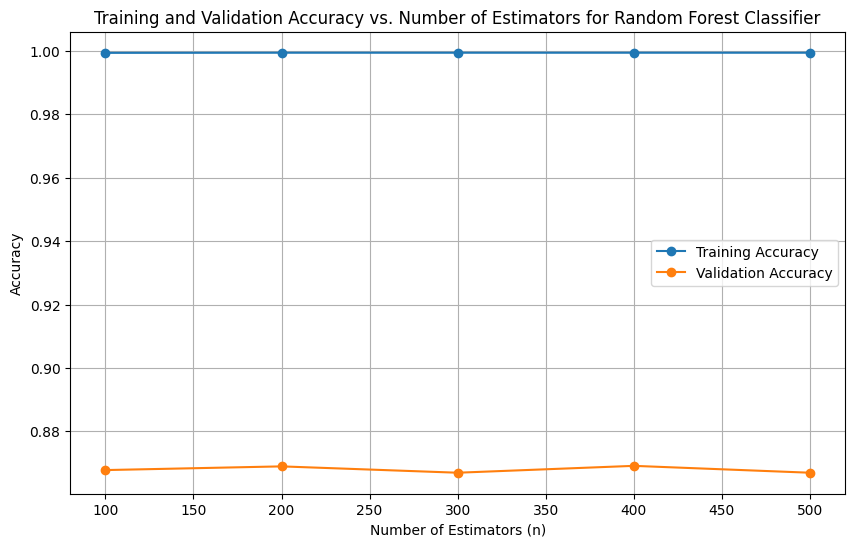

In [ ]:

n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:

    clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

# Model testing comparision

In [ ]:

import time

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)
classifiers = [clf0, clf1, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []

for clf in classifiers:
    start_time1 = time.time()
    clf.fit(X_train, y_train)
    end_time1 = time.time()
    training_time = end_time1 - start_time1
    training_times.append(training_time)

    start_time2 = time.time()
    y_pred = clf.predict(X_test)
    end_time2 = time.time()
    testing_time = end_time2 - start_time2
    testing_times.append(testing_time)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Create and display the results table
test_results = {'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
                'Training Time (s)': [f'{time:.2f}' for time in training_times],
                'Testing Time (s)': [f'{time:.2f}' for time in testing_times]}

df_results = pd.DataFrame(test_results, index=classifier_labels)
display(df_results)

,Accuracy,Training Time (s),Testing Time (s)
NB,88.96%,1.65,0.29
kNN,87.84%,0.24,120.74
SVM,90.96%,2.43,0.14
RF,90.98%,350.56,8.48


#Final testing


In [ ]:
vectorizer = joblib.load('/content/drive/MyDrive/ML/models/tfidf.joblib')
clf = joblib.load('/content/drive/MyDrive/ML/models/clf3.joblib') # I choose SVM here for quick result

with open('/content/drive/MyDrive/ML/stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords]

label_mapping = {
    0: 'Politics',
    1: 'Business',
    2: 'Sports',
    3: 'Education',
    4: 'Wellness',
    5: 'Entertainment'
}

def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

def pre_process(sentence):
    sentence = unicodedata.normalize('NFC', sentence)
    sentence = clean_text(sentence)
    sentence = sentence.replace('kĩ','kỹ').replace('mỳ', 'mì').replace('sỹ', 'sĩ').replace('lí ',' lý ')
    sentence = text_normalize(sentence)
    sentence = word_tokenize(sentence, format='text')
    sentence = sentence.lower()
    sentence = remove_stopwords(sentence)

    return [sentence]

def predict_category(processed_sentence, clf):
    sentence_vector = vectorizer.transform(processed_sentence)
    predicted_category = clf.predict(sentence_vector)

    return predicted_category[0]

sentence = input('Enter the headline: ')

processed_sentence = pre_process(sentence)
predicted_label = predict_category(processed_sentence, clf)

predicted_category = label_mapping[predicted_label]
print('"' + sentence + '"')
print(f"Predicted Category: {predicted_category}")


Enter the headline: những cách ngủ sâu
"những cách ngủ sâu"
Predicted Category: Wellness
